In [1]:
import os
import json
import math
import sys
import argparse
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import wandb

from accelerate import Accelerator
from transformers import get_scheduler

from audiocraft.modules.conditioners import JointEmbedCondition, SegmentWithAttributes, WavCondition, ConditioningAttributes
from config import Config
from audiomodel import AudioProcessing
from audiodataset_seperation import SeperationDataset, TestDataset

def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def wandb_init(cfg):
    wandb.init(
        # set the wandb project where this run will be logged
        project=cfg.wandb_project_name,
        
        # track hyperparameters and run metadata
        config={
            "learning_rate": cfg.learning_rate,
            "dataset": "epidemic",
            "epochs": cfg.num_train_epochs,
            "batch_size": cfg.batch_size,
        }
    )
    
def save_checkpoint(cfg, model, result, best_loss, epoch=0):
    save_checkpoint = False
    with open("{}/summary.jsonl".format(cfg.output_dir), "a") as f:
        f.write(json.dumps(result) + "\n\n")
        
    if result["valid_loss"] < best_loss:
      best_loss = result["valid_loss"]
      save_checkpoint = True
      
    # 모델 상태 저장
    if save_checkpoint and cfg.checkpointing_steps == "best":
        torch.save(model.state_dict(), os.path.join(cfg.output_dir, f"best.pth"))

    #torch.save(model.state_dict(), os.path.join(cfg.output_dir, "last.pth"))
    torch.save(model.state_dict(), os.path.join(cfg.output_dir, f"{epoch}.pth"))

    return best_loss

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.1.0+cu118)
    Python  3.10.13 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [2]:
def build_model(cfg):
        from audiocraft.models.loaders import load_compression_model, load_lm_model
        """Instantiate models and optimizer."""     
        compression_model = load_compression_model('facebook/audiogen-medium', device=cfg.device)
        lm = load_lm_model('facebook/audiogen-medium', device=cfg.device)
        return compression_model, lm

def process_audio_tokenizer(wav, compression_model):
    """
    Get wav audio and return audio tokens
    """
    with torch.no_grad():
        audio_tokens, scale = compression_model.encode(wav)
    return audio_tokens

def post_process_audio_tokenizer(audio_tokens, audio_lengths=None, compression_model=None, lm=None, cfg=None):
    """
    For Masking
    """
    padding_mask = torch.ones_like(audio_tokens, dtype=torch.bool, device=audio_tokens.device)
    audio_tokens = audio_tokens.clone()
    padding_mask = padding_mask.clone()
    token_sample_rate = compression_model.frame_rate
    # B : batch size
    # K : codebook num
    # T_s : duration * 50(임의 지정, encodec's frame rate)
    B, K, T_s = audio_tokens.shape
    
    for i in range(B):
        valid_tokens = math.floor(audio_lengths[i] / cfg.sample_rate * token_sample_rate)
        audio_tokens[i, :, valid_tokens:] = lm.special_token_id # 2048이다.
        padding_mask[i, :, valid_tokens:] = 0

    return audio_tokens, padding_mask

In [3]:
base_path = "./csv_files/"
train_data_path = f"{base_path}/train_dataset_epidemic_sub.csv"
eval_data_path = f"{base_path}/eval_dataset_epidemic_sub.csv"

cfg = Config()

cfg.update(train_data_path=train_data_path, eval_data_path=eval_data_path, batch_size=16)

accelerator = Accelerator(gradient_accumulation_steps=cfg.gradient_accumulation_steps)
cfg.update(device=accelerator.device)
make_dir(cfg.output_dir)
make_dir(cfg.generated_dir)
if accelerator.is_main_process: 
    wandb_init(cfg)

with accelerator.main_process_first():  
    compression_model, lm = build_model(cfg)
    audio_dataset = SeperationDataset(cfg, train=True)
    eval_dataset = SeperationDataset(cfg, train=False)
compression_model.eval()

model = AudioProcessing(cfg, lm)
test_dataset = TestDataset(cfg)

audio_dataloader = DataLoader(audio_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=8)
eval_dataloader = DataLoader(eval_dataset, batch_size=cfg.eval_batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=1)

# gradients for lm
optimizer_parameters = [param for param in model.lm.parameters() if param.requires_grad]

optimizer = torch.optim.AdamW(
    optimizer_parameters, 
    lr=cfg.learning_rate,
    betas=(cfg.adam_beta1, cfg.adam_beta2),
    weight_decay=cfg.adam_weight_decay,
    eps=cfg.adam_epsilon,
)

num_update_steps_per_epoch = math.ceil(len(audio_dataloader) / cfg.gradient_accumulation_steps)
if cfg.max_train_steps is None:
  cfg.max_train_steps = cfg.num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
      name=cfg.lr_scheduler_type,
      optimizer=optimizer,
      num_warmup_steps=cfg.num_warmup_steps * cfg.gradient_accumulation_steps,
      num_training_steps=cfg.max_train_steps * cfg.gradient_accumulation_steps,
  )

with accelerator.main_process_first():
    if cfg.resume_from_checkpoint is not None:
        accelerator.print(f"Resumed from local checkpoint: {cfg.resume_from_checkpoint}")
        # model.load_state_dict(torch.load(cfg.resume_from_checkpoint, map_location=accelerator.device))
        #accelerator.load_state(cfg.resume_from_checkpoint)

audio_dataloader, eval_dataloader, model, compression_model, optimizer, lr_scheduler = accelerator.prepare(
    audio_dataloader, eval_dataloader, model, compression_model, optimizer, lr_scheduler
)

starting_epoch, completed_steps, best_loss, save_epoch = 0, 0, np.inf, 0
progress_bar = tqdm(range(cfg.max_train_steps), disable=not accelerator.is_local_main_process)

wandb: Currently logged in as: optimizerai (optimizer_ai). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Resumed from local checkpoint: ./output_dir_finetune/best.pth


  0%|          | 0/2575000 [00:00<?, ?it/s]

In [4]:
# from huggingface_hub import hf_hub_download
# hf_hub_download(repo_id="youngdicey/audiogen-finetuning-weight-10pth", filename="output_dir_finetune/best.pth", local_dir="./output_dir_finetune/best.pth")

In [5]:
model.eval()
compression_model.eval()
if accelerator.is_main_process:
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_vae = accelerator.unwrap_model(compression_model)
    audio_num = 1
    gen_tokens, gen_audio = unwrapped_model.inference(["the sound of barking dogs"], unwrapped_vae)
    prompt = "thesoundofcar"
    audio_filename = f"{prompt}_{audio_num}.wav"
    unwrapped_model.save_audio(gen_audio, audio_filename, cfg)
    from IPython.display import Audio
    display(Audio(data=gen_audio[0].detach().cpu().numpy(), rate=cfg.sample_rate))

del unwrapped_model
del unwrapped_vae
del gen_tokens
del gen_audio
torch.cuda.empty_cache()

In [6]:
# unwrapped_vae = accelerator.unwrap_model(compression_model)

# synthesized_audio, prompt, ground_truth, length = next(iter(audio_dataloader))

# print(synthesized_audio.shape)
# print(prompt)
# print(ground_truth.shape)
# print(length)

# synthesized_audio_tokens = process_audio_tokenizer(synthesized_audio, unwrapped_vae)
# synthesized_audio_tokens, synthesized_padding_mask = post_process_audio_tokenizer(synthesized_audio_tokens, length, unwrapped_vae, lm, cfg)

# ground_truth_tokens = process_audio_tokenizer(ground_truth, unwrapped_vae)
# ground_truth_tokens, ground_truth_padding_mask = post_process_audio_tokenizer(ground_truth_tokens, length, unwrapped_vae, lm, cfg)


# print("padding_mask : ", ground_truth_padding_mask)

# cona = torch.concatenate((synthesized_audio_tokens, ground_truth_tokens), dim=2)
# cona_mask = torch.concatenate((synthesized_padding_mask, ground_truth_padding_mask), dim=2)
# print(cona_mask.shape)
# print(cona.shape, "\n\n------\n\n")
# cona_mask[:, :, :150] = 0
# print(cona_mask.shape)
# print(cona_mask)

# # # for batch_idx, (synthesized_wav, prompts, ground_truth, lengths) in enumerate(audio_dataloader):
# # #     print(batch_idx)
# # #     if batch_idx == 4:
# # #         break

# attributes = [
#     ConditioningAttributes(text={'description': str(description)})
#     for description in prompt
# ]

# loss, model_output = model(cona, cona_mask, attributes)

# print("\n\nloss : ", loss, "\n\n")

# del unwrapped_vae
# del loss
# del model_output
# torch.cuda.empty_cache()

-------------------EPOCH0-------------------------


  0%|          | 100/2575000 [07:20<2910:59:29,  4.07s/it]

batch_idx : 99 tensor(0.9322)


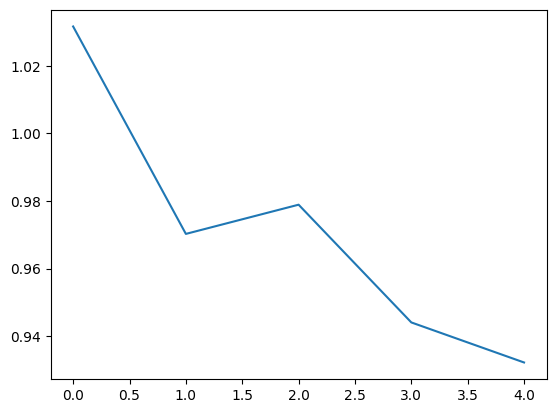

  0%|          | 200/2575000 [14:33<3294:30:49,  4.61s/it]

batch_idx : 199 tensor(0.9292)


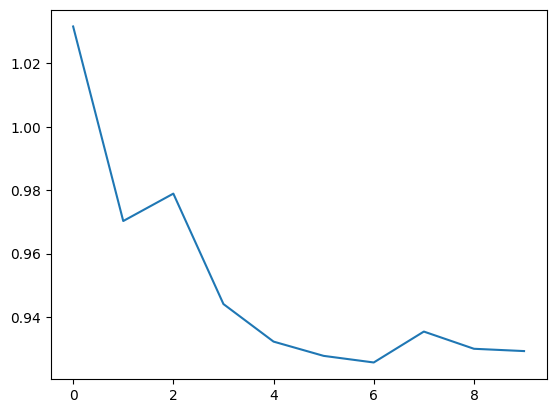

  0%|          | 300/2575000 [21:43<3137:46:18,  4.39s/it]

batch_idx : 299 tensor(0.9217)


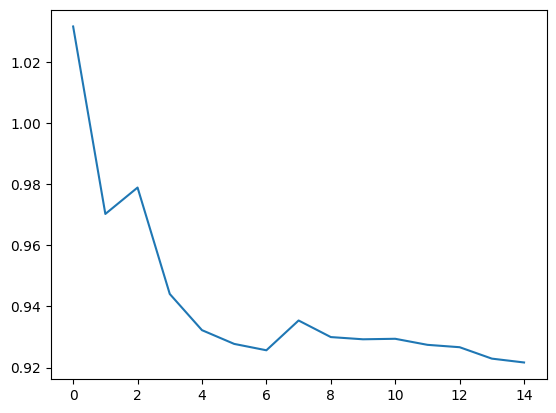

  0%|          | 400/2575000 [28:50<2988:17:39,  4.18s/it]

batch_idx : 399 tensor(0.9116)


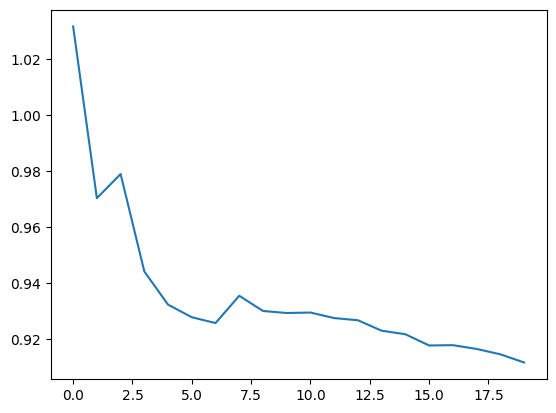

  0%|          | 500/2575000 [36:01<3075:22:38,  4.30s/it]

batch_idx : 499 tensor(0.9068)


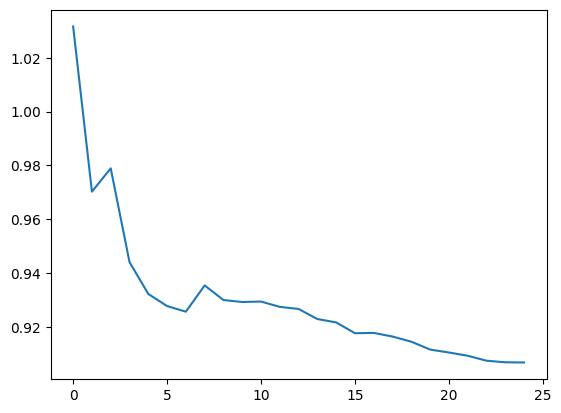

  0%|          | 600/2575000 [43:12<3088:25:27,  4.32s/it]

batch_idx : 599 tensor(0.9041)


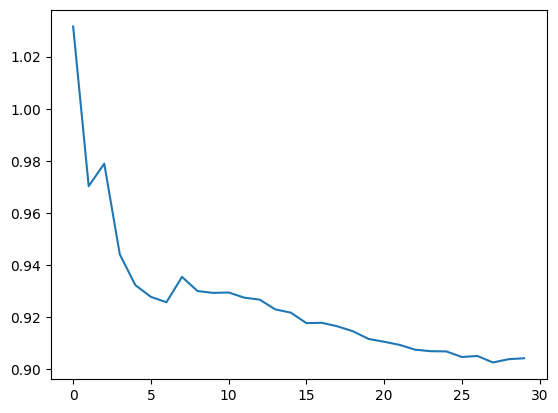

  0%|          | 700/2575000 [50:21<2955:50:10,  4.13s/it]

batch_idx : 699 tensor(0.9030)


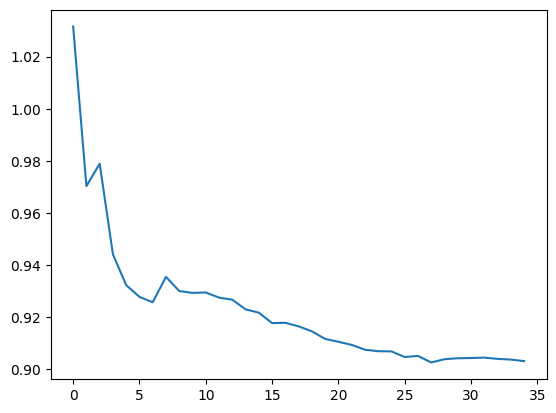

  0%|          | 800/2575000 [57:30<2974:36:46,  4.16s/it]

batch_idx : 799 tensor(0.9010)


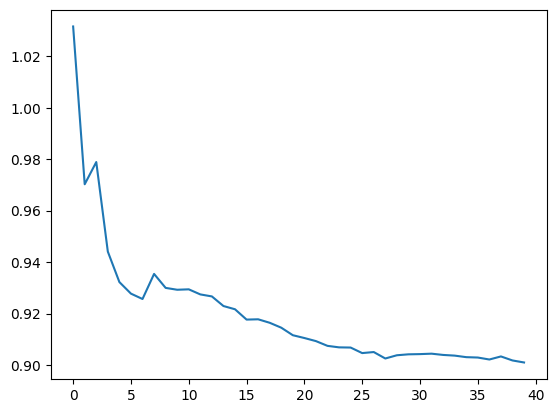

  0%|          | 900/2575000 [1:04:42<3048:53:00,  4.26s/it]

batch_idx : 899 tensor(0.9018)


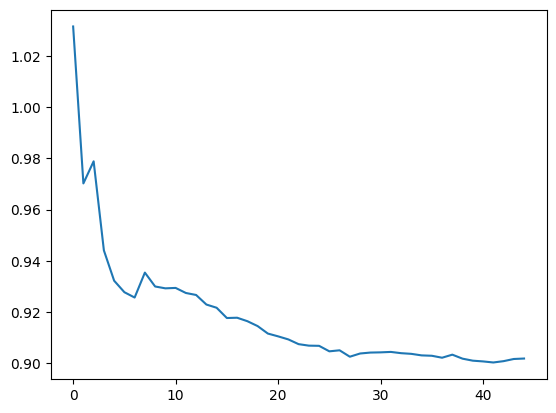

  0%|          | 1000/2575000 [1:11:50<3013:42:49,  4.21s/it]

batch_idx : 999 tensor(0.9016)


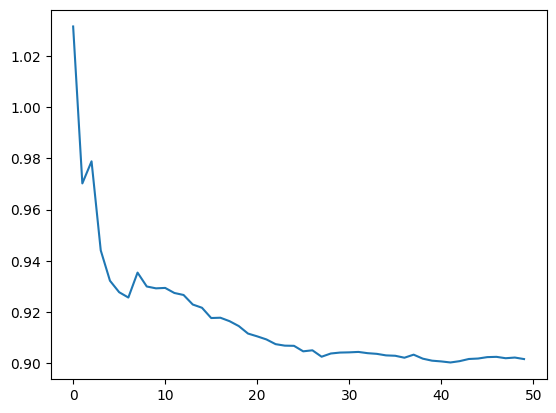

  0%|          | 1100/2575000 [1:19:03<3105:38:08,  4.34s/it]

batch_idx : 1099 tensor(0.8994)


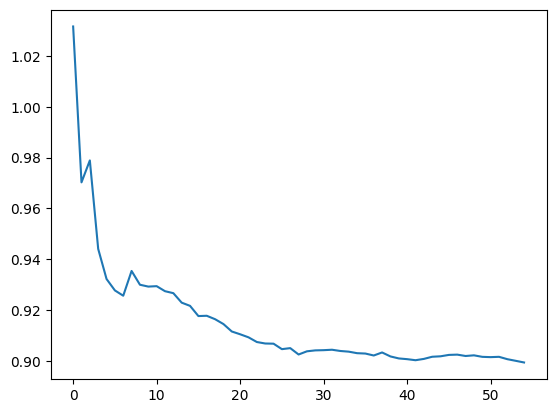

  0%|          | 1145/2575000 [1:22:17<3250:57:36,  4.55s/it]

In [ ]:
losses = []

for epoch in range(starting_epoch, cfg.num_train_epochs):
    accelerator.print(f"-------------------EPOCH{epoch}-------------------------" )
    total_loss, total_val_loss = 0, 0
    temp_loss = 0
    model.train()
    # compression_model.train()
    for batch_idx, (synthesized_wav, prompts, ground_truth, lengths) in enumerate(audio_dataloader):
        # Consider batch
        with accelerator.accumulate(model):
            # print(1)
            with torch.no_grad():
                unwrapped_vae = accelerator.unwrap_model(compression_model)
                synthesized_audio_tokens = process_audio_tokenizer(synthesized_wav, unwrapped_vae)
                synthesized_audio_tokens, synthesized_padding_mask = post_process_audio_tokenizer(synthesized_audio_tokens, lengths, unwrapped_vae, lm, cfg)
                # print(2)
                
                audio_tokens = process_audio_tokenizer(ground_truth, unwrapped_vae)
                audio_tokens, padding_mask = post_process_audio_tokenizer(audio_tokens, lengths, unwrapped_vae, lm, cfg)
                # print(3)
                
                attributes = [
                    ConditioningAttributes(text={'description': str(description)})
                    for description in prompts
                ]
            # print(3)

            mask_token_seperation = torch.tensor([[[lm.special_token_id],[lm.special_token_id],[lm.special_token_id],[lm.special_token_id]]]*cfg.batch_size).to(accelerator.device)
            mask_padding_token_seperation = torch.zeros(mask_token_seperation.shape, dtype=bool).to(accelerator.device)

            made_up_tokens = torch.concatenate((synthesized_audio_tokens, mask_token_seperation, audio_tokens), dim=2)
            made_padding_tokens = torch.concatenate((synthesized_padding_mask, mask_padding_token_seperation, padding_mask), dim=2)
            # print(4)
            made_padding_tokens[:, :, :150]=0
            
            loss, model_output = model(made_up_tokens, made_padding_tokens, attributes)
            # print(5)
            ppl =  torch.exp(loss)
            total_loss += loss.detach().cpu().float()
            accelerator.backward(loss)     
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            torch.cuda.empty_cache()
            
            if accelerator.sync_gradients:
                progress_bar.update(1)
                completed_steps += 1
            
            if batch_idx % 20==19:
                losses.append(total_loss/batch_idx)
            
            if batch_idx % 100==99:
                print(f"batch_idx : {batch_idx}", total_loss/batch_idx)
                plt.plot(losses)
                plt.show()

    torch.cuda.empty_cache()
    # save checkpoint every epoch
    torch.save(model.state_dict(), f"./sep_models/lr_mod_model_epochs_{epoch}_.pth")

    print("start evaluation")
    model.eval()
    for batch_idx, (synthesized_wav, prompts, ground_truth, lengths) in enumerate(eval_dataloader):
        # Consider batch
        with accelerator.accumulate(model):
            # print(1eval)
            with torch.no_grad():
                unwrapped_vae = accelerator.unwrap_model(compression_model)
                synthesized_audio_tokens = process_audio_tokenizer(synthesized_wav, unwrapped_vae)
                synthesized_audio_tokens, synthesized_padding_mask = post_process_audio_tokenizer(synthesized_audio_tokens, lengths, unwrapped_vae, lm, cfg)
                # print(2eval)
                
                audio_tokens = process_audio_tokenizer(ground_truth, unwrapped_vae)
                audio_tokens, padding_mask = post_process_audio_tokenizer(audio_tokens, lengths, unwrapped_vae, lm, cfg)
                # print(3eval)
                
                attributes = [
                    ConditioningAttributes(text={'description': str(description)})
                    for description in prompts
                ]
            mask_token_seperation = torch.tensor([[[lm.special_token_id],[lm.special_token_id],[lm.special_token_id],[lm.special_token_id]]]*cfg.eval_batch_size).to(accelerator.device)
            mask_padding_token_seperation = torch.zeros(mask_token_seperation.shape, dtype=bool).to(accelerator.device)

            made_up_tokens = torch.concatenate((synthesized_audio_tokens, mask_token_seperation, audio_tokens), dim=2)
            made_padding_tokens = torch.concatenate((synthesized_padding_mask, mask_padding_token_seperation, padding_mask), dim=2)
            # print(4eval)
            made_padding_tokens[:, :, :150]=0
            
            loss, model_output = model(made_up_tokens, made_padding_tokens, attributes)
            total_val_loss += loss.cpu().detach()
    
    del model_output
    del loss
    torch.cuda.empty_cache()
    print("total_val_loss : ", total_val_loss)

    # reocrd to wandb
    if accelerator.is_main_process:         
        result = {}
        result["epoch"] = save_epoch + 1,
        result["step"] = completed_steps
        result["train_loss"] = round(total_loss.item()/cfg.save_steps, 4)
        result["valid_loss"] = round(total_val_loss.item()/len(eval_dataloader), 4)
        
        wandb.log(result)
        result_string = "Epoch: {}, Loss Train: {}, Valid: {}\n".format(save_epoch + 1, result["train_loss"], result["valid_loss"])
        print(result_string)

In [ ]:
# 위의 모델을 가지고 inference하기